In [1]:
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from astropy.io import fits
import tqdm
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import nmmn.plots
import vorbin
wolfram=nmmn.plots.wolframcmap() # for Mathematica's cmap
parula=nmmn.plots.parulacmap() # for MATLAB's cmap
turbo=nmmn.plots.turbocmap() # Turbo
import warnings
warnings.filterwarnings('ignore')
import galpy
from galpy.util import coords
from galpy.potential import IsochronePotential
from galpy.actionAngle import actionAngleIsochrone
# from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import estimateDeltaStaeckel
from astropy.io import fits
import tqdm
from galpy.orbit import Orbit
from galpy.potential.mwpotentials import McMillan17
from galpy.util.conversion import get_physical
from galpy.actionAngle import UnboundError


A new version of galpy (1.9.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
import h5py
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
# f.keys() # this would list all the APOGEE IDs, including doubles for half-integer bins
median_knot_probability = []
median_bar_probability = []
median_disc_probability = []
std_knot_probability = []
std_bar_probability = []
std_disc_probability = []
all_knot_probability = []
all_bar_probability = []
all_disc_probability = []
RxyzL = []


for key in tqdm.tqdm_notebook(f.keys()):
    median_knot_probability.append(np.nanmedian(f[key][:,2]))
    median_bar_probability.append(np.nanmedian(f[key][:,1]))
    median_disc_probability.append(np.nanmedian(f[key][:,0]))
    std_knot_probability.append(np.nanstd(f[key][:,2]))
    std_bar_probability.append(np.nanstd(f[key][:,1]))
    std_disc_probability.append(np.nanstd(f[key][:,0]))
    all_knot_probability.append((f[key][:,2]))
    all_bar_probability.append((f[key][:,1]))
    all_disc_probability.append((f[key][:,0]))
    RxyzL.append(f[key][:,3][:7])
f.close() # don't forget to close the file!


  0%|          | 0/32489 [00:00<?, ?it/s]

In [3]:
mask_knot = (np.array(median_knot_probability)>0.5)&(np.array(std_knot_probability)<0.15)
mask_bar = (np.array(median_bar_probability)>0.85)&(np.array(std_bar_probability)<0.15)
mask_disc = (np.array(median_disc_probability)>0.85)&(np.array(std_disc_probability)<0.15)

In [4]:
RxyzL_ = np.array(RxyzL)

In [5]:
R = RxyzL_[:,0]
x = RxyzL_[:,1]
y = RxyzL_[:,2]
z = RxyzL_[:,3]
Lx = RxyzL_[:,4]
Ly = RxyzL_[:,5]
Lz = RxyzL_[:,6]

In [6]:
print(len(RxyzL_[mask_knot]))
print(len(RxyzL_[mask_bar]))
print(len(RxyzL_[mask_disc]))

636
3339
20514


In [7]:
import h5py
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
apo_ids = []
for key in tqdm.tqdm_notebook(f.keys()):
    new_key = key.replace("*", "")
    apo_ids.append(new_key)
f.close() # don't forget to close the file!


  0%|          | 0/32489 [00:00<?, ?it/s]

In [8]:
import h5py
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
apo_ids2 = []
for key in tqdm.tqdm_notebook(f.keys()):
    if '*' in key:
        pass
    else:
        apo_ids2.append(key)
f.close() # don't forget to close the file!
     

  0%|          | 0/32489 [00:00<?, ?it/s]

In [9]:
import h5py
f = h5py.File("/Users/dhortadarrington/Documents/Projects/mw-bar/data/AllClassifications_APOGEE_all_feh8_SNRc.h5","r")
apo_ids3 = []
for key in tqdm.tqdm_notebook(f.keys()):
    apo_ids3.append(key)
f.close() # don't forget to close the file!
     


  0%|          | 0/32489 [00:00<?, ?it/s]

In [10]:
print(len(apo_ids3))
print(len(apo_ids2))
# print(len(data_all))

32489
18271


In [11]:
mask_u = np.isin(apo_ids3,apo_ids2)


In [12]:
path = '/Users/dhortadarrington/Documents/Projects/mw-bar/data/table_centroids.fits'
tb = fits.open(path)
data = tb[1].data 

In [13]:
mask_cen_knot = np.where(data['comp']=='knot')
mask_cen_bar = np.where(data['comp']=='bar')
mask_cen_disc = np.where(data['comp']=='disc')


In [14]:
path_all = '/Users/dhortadarrington/Documents/Projects/mw-bar/data/4Mike-innergal-bar-gaiadists'
tb_all = fits.open(path_all)
data_all = tb_all[1].data 
print(len(data_all))

21742


In [15]:
def dat_to_galcen(dat,
                  return_rphiz =True,
                  verbose =False,
                  ro = 8.275,  # GRAVITY 2018 value 
                  vo = 220.,   # GRAVITY 2018 value 
                  zo = 0.02,    # Bennet and Bovy 2018 value
                  keys = ['ra', 'dec', 'GAIAEDR3_R_MED_PHOTOGEO', 'pmra', 'pmdec', 'VHELIO_AVG'],
                  #cov_keys = [dat['pmra_error_1'],dat['pmdec_error_1'],dat['SH_weighted_diststd'],dat['VERR_1']],
                  parallax = False):
    vxvv = np.dstack([dat[keys[i]] for i in range(len(keys))])[0]
    ra, dec= vxvv[:,0], vxvv[:,1]
    lb= coords.radec_to_lb(ra,dec,degree=True, epoch=None)
    pmra, pmdec= vxvv[:,3], vxvv[:,4]
    pmllpmbb= coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
    d, vlos= vxvv[:,2]/1e3, vxvv[:,5]
    if parallax:
        d = 1./d
    rectgal= coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
    vsolar= np.array([-11.1,26.5,7.25]) # Values from Ted's halo paper, taken from Schrondich 2010 and adjusted given by the proper motion values for SGR A* by the GRAVITY collaboration. Vx is negative because we adopt the x convention to go in opposite direction
    vsun= np.array([0.,1.,0.,])+vsolar/vo
    X = rectgal[:,0]/ro
    Y = rectgal[:,1]/ro
    Z = rectgal[:,2]/ro
    vx = rectgal[:,3]/vo
    vy = rectgal[:,4]/vo
    vz = rectgal[:,5]/vo
    XYZ = np.dstack([X, Y, Z])[0]
    vxyz = np.dstack([vx,vy,vz])[0]
    Rpz = coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
    vRvTvz = coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                                    vsun=vsun,
                                                                    Xsun=1.,
                                                                    Zsun=zo/ro,
                                                                    galcen=True)
    return XYZ, vxyz, Rpz, vRvTvz

In [16]:
xyz,vxyz,Rpz,vRvTvz = dat_to_galcen(data_all)

In [17]:
Rgal = Rpz[:,0]*8.275
Zgal = Rpz[:,2]*8.275

rads = np.sqrt(Rgal**2+Zgal**2)

In [18]:
path = '/Users/dhortadarrington/Documents/Projects/mw-bar/data/table_centroids.fits'
tb = fits.open(path)
data = tb[1].data 

In [19]:
mask_disc_cen = np.where(data['comp']=='disc')
mask_knot_cen = np.where(data['comp']=='knot')
mask_bar_cen = np.where(data['comp']=='bar')

In [20]:
lx_cen = data['Lx']
lx_std_cen = (data['Lx+']-data['Lx-'])/2
ly_cen = data['Ly']
lz_cen = data['Lz']


In [21]:
mask_knot = (np.array(median_knot_probability)>0.5)&(np.array(std_knot_probability)<0.15 )
mask_bar = (np.array(median_bar_probability)>0.8)&(np.array(std_bar_probability)<0.1 )
mask_disc = (np.array(median_disc_probability)>0.8)&(np.array(std_disc_probability)<0.1)

TypeError: print_pdf() got an unexpected keyword argument 'fmt'

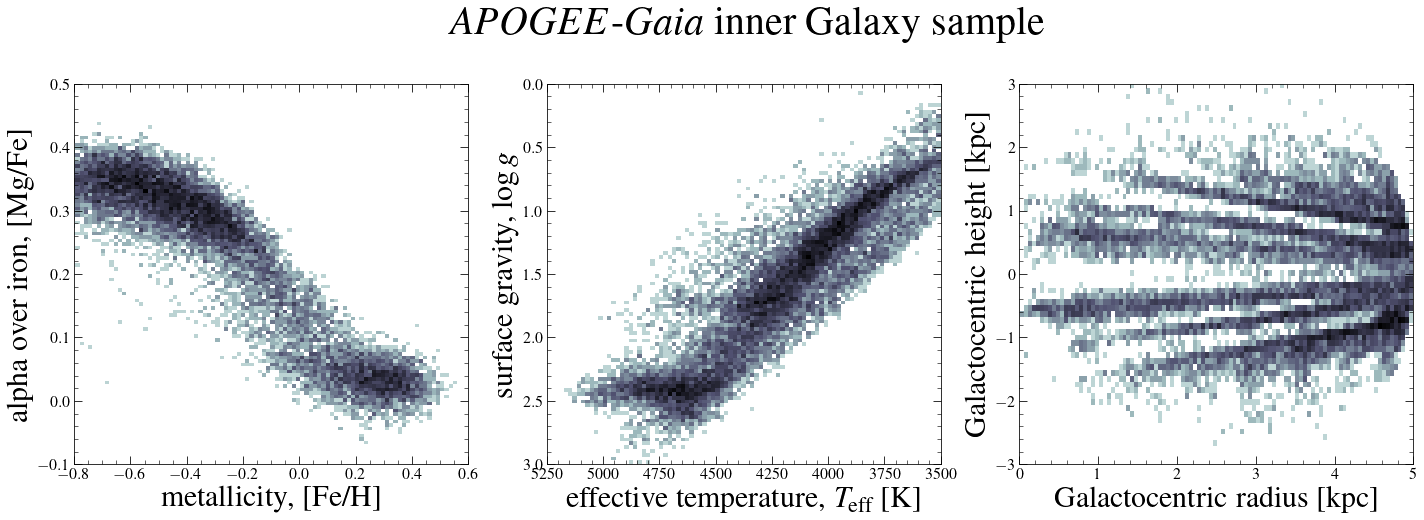

In [22]:
from matplotlib.colors import LogNorm
fig, ax_nstd = plt.subplots(1,3, figsize=(24,7),facecolor='white')

dependency_nstd = [[0.8, 0.75],
                   [-0.2, 0.35]]
mu = 0, 0
scale = 8, 5


# Mg-fe
ax_nstd[0].hist2d(data_all['FE_H'][data_all['MG_FE']>-10],data_all['MG_FE'][data_all['MG_FE']>-10],bins=200,cmap='bone_r',norm=LogNorm())
ax_nstd[0].set_xlabel(r'metallicity, [Fe/H]',fontsize=30)
ax_nstd[0].set_ylabel(r'alpha over iron, [Mg/Fe]',fontsize=30)
ax_nstd[0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
ax_nstd[0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax_nstd[0].minorticks_on()
ax_nstd[0].set_xlim(-0.8,0.6)
ax_nstd[0].set_ylim(-0.1,0.5)
# cb = ax_nstd[0,0].colorbar(orientation='horizontal',location='top')
# cb.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=20)
# cb.ax.tick_params(labelsize=20)
# cax = axes[0,0].inset_axes([0.15, 1.08, 0.7, 0.05])
# cbar = fig.colorbar(color,orientation='horizontal',location='top')
# cbar.set_label(label=r'N$_{\mathrm{stars}}$',fontsize=30,labelpad=10)
# cbar.ax.tick_params(labelsize=20,pad=1)
# cbar.ax.xaxis.set_ticks_position('top')
# cbar.ax.xaxis.set_label_position('top')


# teff-logg
ax_nstd[1].set_title('$APOGEE$-$Gaia$ inner Galaxy sample',fontsize=40,pad=50)
ax_nstd[1].hist2d(data_all['TEFF'][data_all['LOGG']>-10],data_all['LOGG'][data_all['LOGG']>-10],bins=100,cmap='bone_r',norm=LogNorm())
ax_nstd[1].set_xlabel(r'effective temperature, $T_{\mathrm{eff}}$ [K]',fontsize=30)
ax_nstd[1].set_ylabel(r'surface gravity, $\log g$',fontsize=30)
ax_nstd[1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
ax_nstd[1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax_nstd[1].minorticks_on()
ax_nstd[1].set_xlim(5250,3500)
ax_nstd[1].set_ylim(3,0.)

# R-z

ax_nstd[2].hist2d(Rgal[Zgal>-10],Zgal[Zgal>-10],bins=100,cmap='bone_r',norm=LogNorm())
ax_nstd[2].set_xlabel(r'Galactocentric radius [kpc]',fontsize=30)
ax_nstd[2].set_ylabel(r'Galactocentric height [kpc]',fontsize=30)
ax_nstd[2].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
ax_nstd[2].tick_params(which='minor', length=4, direction='in',top=True,right=True)
ax_nstd[2].minorticks_on()
ax_nstd[2].set_xlim(0.,5)
ax_nstd[2].set_ylim(-3,3)

plt.savefig('../plots-paper/data.pdf',dpi=600,fmt='pdf', rasterized=True, bbox_inches = 'tight')




# Plot the $\alpha$-Fe plane

as we have chains for the probabilities of every star, we will compute the alpha-Fe plane $\times$ the number of chains, weighted by the probabilities, and then take the average

In [23]:
def get_2dhist(xs,ys,weights):
    nbins = 20
    # compute the weighted 2d histogram
    xlin = np.linspace(-0.8,0.8,51)
    ylin = np.linspace(-0.2,0.5,51)
    hist, xedges, yedges = np.histogram2d(xs, ys, bins=[xlin,ylin], weights=weights)
    extent = [xedges[0],xedges[-1], yedges[0], yedges[-1]]
    hist = np.rot90(hist)
    return hist,xedges,yedges



In [24]:
mask_un = np.isin(data_all['APOGEE_ID'],apo_ids2)
print(len(data_all[mask_un]))
print(len(data_all['APOGEE_ID']))

18271
21742


(array([0.0025364 , 0.01308583, 0.0316019 , 0.05390795, 0.1599387 ,
        0.26506586, 0.33722005, 0.44225099, 0.50661344, 0.54945312,
        0.52630857, 0.62148244, 0.43286116, 0.37210452, 0.38193097,
        0.76917324, 0.81820714, 0.26878479, 0.0882137 , 0.03196013]),
 array([6.28210604e-04, 1.50492564e-01, 3.00356925e-01, 4.50221270e-01,
        6.00085616e-01, 7.49949992e-01, 8.99814308e-01, 1.04967868e+00,
        1.19954300e+00, 1.34940743e+00, 1.49927175e+00, 1.64913607e+00,
        1.79900050e+00, 1.94886482e+00, 2.09872913e+00, 2.24859357e+00,
        2.39845777e+00, 2.54832220e+00, 2.69818664e+00, 2.84805083e+00,
        2.99791527e+00]),
 [<matplotlib.patches.Polygon at 0x2b9a6c700>])

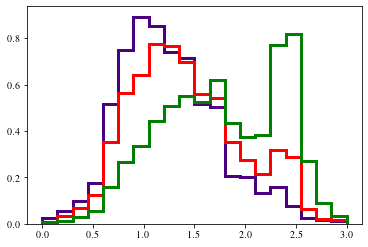

In [25]:
plt.hist(data_all['LOGG'][mask_un],20,weights=np.array(median_knot_probability)[mask_u],color='indigo',histtype='step',lw=3,label='Knot/box',density=True)
plt.hist(data_all['LOGG'][mask_un],20,weights=np.array(median_bar_probability)[mask_u],color='r',histtype='step',lw=3,label='Knot/box',density=True)
plt.hist(data_all['LOGG'][mask_un],20,weights=np.array(median_disc_probability)[mask_u],color='g',histtype='step',lw=3,label='Knot/box',density=True)


In [26]:
mask_logg = (data_all['LOGG'][mask_un]>0.5)&(data_all['LOGG'][mask_un]<1.5)&(rads[mask_un]<3)
# &(rads[mask_un]<3)

knot_probs = np.array(all_knot_probability)[mask_u][mask_logg].T
bar_probs = np.array(all_bar_probability)[mask_u][mask_logg].T
disc_probs = np.array(all_disc_probability)[mask_u][mask_logg].T

hist_knot = np.zeros((len(knot_probs),50,50))
hist_bar = np.zeros((len(bar_probs),50,50))
hist_disc = np.zeros((len(disc_probs),50,50))

for indx, i in enumerate(knot_probs):
    hist_knot[indx],xedges_knot,yedges_knot = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_all['MG_FE'][mask_un][mask_logg],i)
    hist_bar[indx],xedges_bar,yedges_bar = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_all['MG_FE'][mask_un][mask_logg],bar_probs[indx])
    hist_disc[indx],xedges_disc,yedges_disc = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_all['MG_FE'][mask_un][mask_logg],disc_probs[indx])


In [27]:
def get_2dhist_solar(xs,ys):
    nbins = 20
    # compute the weighted 2d histogram
    xlin = np.linspace(-0.8,0.8,51)
    ylin = np.linspace(-0.2,0.5,51)
    hist, xedges, yedges = np.histogram2d(xs, ys, bins=[xlin,ylin])
    extent = [xedges[0],xedges[-1], yedges[0], yedges[-1]]
    hist = np.rot90(hist)
    return hist,xedges,yedges


In [28]:
path_all2 = '/Users/dhortadarrington/Documents/Master/data/dr17_dr3_McMillan_astroNN_rev1.fits'
tb_all2 = fits.open(path_all2)
data_todo = tb_all2[1].data 


In [29]:
Lx_todo = np.load('/Users/dhortadarrington/Documents/Projects/accreted-systems/samples/Lx_full_dr17.npy',allow_pickle=True)
Ly_todo = np.load('/Users/dhortadarrington/Documents/Projects/accreted-systems/samples/Ly_full_dr17.npy',allow_pickle=True)
Lz_todo = np.load('/Users/dhortadarrington/Documents/Projects/accreted-systems/samples/Lz_full_dr17.npy',allow_pickle=True)
print(len(Lx_todo),len(data_todo))


733900 733900


In [30]:
mask_solar_1 = np.load('/Users/dhortadarrington/Documents/Projects/mw-bar/sav/mask_solar.npy',allow_pickle=True)
mask_solar = mask_solar_1&(data_todo['LOGG']>0.5)&(data_todo['LOGG']<1.5) 
# &(np.abs(data_todo['Zgal']*8.178)<0.3)
hist_solar,xedges,yedges = get_2dhist_solar(data_todo['FE_H'][mask_solar],data_todo['MG_FE'][mask_solar])


In [31]:
mask_logg = (data_all['LOGG'][mask_un]>0.5)&(data_all['LOGG'][mask_un]<1.5)&(rads[mask_un]<3)
# &(np.abs(Zgal[mask_un])<0.3)

knot_probs = np.array(all_knot_probability)[mask_u][mask_logg].T
bar_probs = np.array(all_bar_probability)[mask_u][mask_logg].T
disc_probs = np.array(all_disc_probability)[mask_u][mask_logg].T

hist_knot_1d = np.zeros((len(knot_probs),10))
hist_bar_1d = np.zeros((len(bar_probs),10))
hist_disc_1d = np.zeros((len(disc_probs),10))

for indx, i in enumerate(knot_probs):
    hist_knot_1d[indx],binedges_knot = np.histogram(data_all['FE_H'][mask_un][mask_logg],bins= np.linspace(-0.8,0.8,11),weights=i)
    hist_bar_1d[indx],binedges_bar = np.histogram(data_all['FE_H'][mask_un][mask_logg],bins= np.linspace(-0.8,0.8,11),weights=bar_probs[indx])
    hist_disc_1d[indx],binedges_disc = np.histogram(data_all['FE_H'][mask_un][mask_logg],bins= np.linspace(-0.8,0.8,11),weights=disc_probs[indx])
 

In [32]:
print(len(np.array(all_knot_probability)[mask_u][mask_logg]))
print(len(data_all['FE_H'][mask_un][mask_logg]))

3761
3761


In [33]:
print(np.shape(knot_probs))
print(np.shape(data_all['FE_H'][mask_un][mask_logg]))

(20, 3761)
(3761,)


(array([0.23154725, 0.31936119, 0.43140008, 0.67486287, 0.78245051,
        0.74994048, 0.97425933, 1.0638954 , 0.94535464, 1.21186198,
        1.23033195, 1.17152824, 1.5351548 , 1.3623908 , 1.27742666,
        1.29591856, 1.30340044, 1.1401955 , 1.20318269, 1.11742111]),
 array([0.50103652, 0.55098188, 0.60092723, 0.65087259, 0.70081794,
        0.7507633 , 0.80070859, 0.85065395, 0.9005993 , 0.95054466,
        1.00048995, 1.0504353 , 1.10038066, 1.15032601, 1.20027137,
        1.25021672, 1.30016208, 1.35010743, 1.40005279, 1.44999814,
        1.49994349]),
 [<matplotlib.patches.Polygon at 0x2bcbe83d0>])

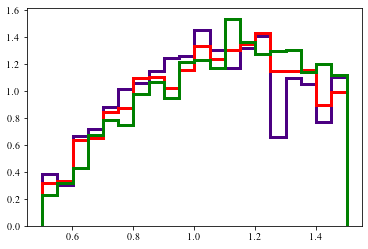

In [34]:
plt.hist(data_all['LOGG'][mask_un][mask_logg],20,weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot/box',density=True)
plt.hist(data_all['LOGG'][mask_un][mask_logg],20,weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Knot/box',density=True)
plt.hist(data_all['LOGG'][mask_un][mask_logg],20,weights=np.array(median_disc_probability)[mask_u][mask_logg],color='g',histtype='step',lw=3,label='Knot/box',density=True)


# cut the logg for the abundance plots between 1.5 and 0.5, and only select stars within 3 kpc from the centre for inner galaxy populations (to account for radial metalliticy gradients)

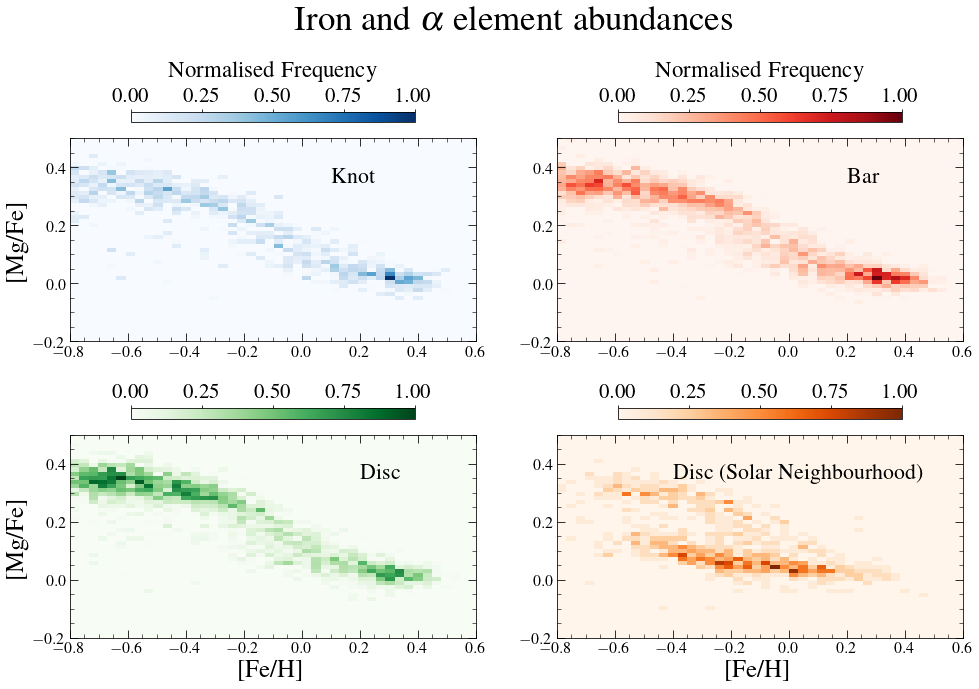

In [76]:

fig, axes = plt.subplots(2, 2,figsize=(16,10),facecolor='white')

plt.figtext(0.32, 1.,r'Iron and $\alpha$ element abundances',fontsize=35)

color = axes[0,0].imshow((np.nanmedian(hist_knot,axis=0)/np.max(np.nanmedian(hist_knot,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Blues')
axes[0,0].text(0.1,0.35,'Knot',fontsize=22)
# axes[0,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[0,0].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,0].minorticks_on()
axes[0,0].set_xlim(-0.8,0.6)
axes[0,0].set_ylim(-0.2,0.5)
cax = axes[0,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,0],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[0,1].imshow((np.nanmedian(hist_bar,axis=0)/np.max(np.nanmedian(hist_bar,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Reds')
axes[0,1].text(0.2,0.35,'Bar',fontsize=22)
# axes[0,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[0,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,1].minorticks_on()
axes[0,1].set_xlim(-0.8,0.6)
axes[0,1].set_ylim(-0.2,0.5)
cax = axes[0,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,1],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,0].imshow((np.nanmedian(hist_disc,axis=0)/np.max(np.nanmedian(hist_disc,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Greens')
axes[1,0].text(0.2,0.35,'Disc',fontsize=22)
axes[1,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[1,0].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,0].minorticks_on()
axes[1,0].set_xlim(-0.8,0.6)
axes[1,0].set_ylim(-0.2,0.5)
cax = axes[1,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,0],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,1].imshow(hist_solar/np.max(hist_solar), extent=[-0.8,0.8,-0.2,0.5],cmap='Oranges')
axes[1,1].text(-.4,0.35,'Disc (Solar Neighbourhood)',fontsize=22)
axes[1,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[1,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,1].minorticks_on()
axes[1,1].set_xlim(-0.8,0.6)
axes[1,1].set_ylim(-0.2,0.5)
cax = axes[1,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,1],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,0].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[2,0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,0].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,0].minorticks_on()
# axes[2,0].set_xlim(-0.8,0.6)
# axes[2,0].set_ylim(0.,2)

# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,1].set_xlabel(r'[Mg/Fe]',fontsize=25)
# axes[2,1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,1].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,1].minorticks_on()
# axes[2,1].set_xlim(-0.2,0.5)
# axes[2,1].set_ylim(0.,10)

plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-alpha.pdf',dpi=600, bbox_inches = 'tight')


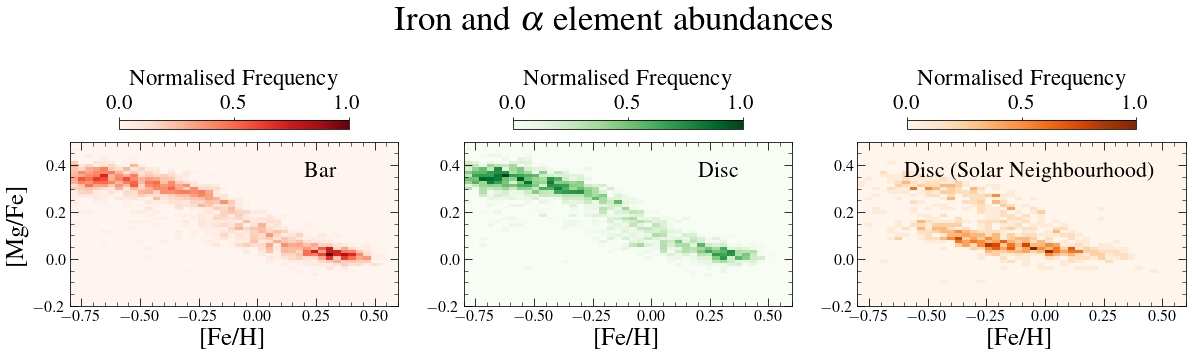

In [46]:

fig, axes = plt.subplots(1, 3,figsize=(20,6),facecolor='white')

plt.figtext(0.35, 0.95,r'Iron and $\alpha$ element abundances',fontsize=35)

color = axes[0].imshow((np.nanmedian(hist_bar,axis=0)/np.max(np.nanmedian(hist_bar,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Reds')
axes[0].text(0.2,0.35,'Bar',fontsize=22)
axes[0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[0].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0].minorticks_on()
axes[0].set_xlim(-0.8,0.6)
axes[0].set_ylim(-0.2,0.5)
cax = axes[0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1].imshow((np.nanmedian(hist_disc,axis=0)/np.max(np.nanmedian(hist_disc,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Greens')
axes[1].text(0.2,0.35,'Disc',fontsize=22)
axes[1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[0,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1].minorticks_on()
axes[1].set_xlim(-0.8,0.6)
axes[1].set_ylim(-0.2,0.5)
cax = axes[1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[2].imshow(hist_solar/np.max(hist_solar), extent=[-0.8,0.8,-0.2,0.5],cmap='Oranges')
axes[2].text(-.6,0.35,'Disc (Solar Neighbourhood)',fontsize=22)
axes[2].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[1,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[2].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[2].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[2].minorticks_on()
axes[2].set_xlim(-0.8,0.6)
axes[2].set_ylim(-0.2,0.5)
cax = axes[2].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[2],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,0].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[2,0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,0].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,0].minorticks_on()
# axes[2,0].set_xlim(-0.8,0.6)
# axes[2,0].set_ylim(0.,2)

# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,1].set_xlabel(r'[Mg/Fe]',fontsize=25)
# axes[2,1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,1].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,1].minorticks_on()
# axes[2,1].set_xlim(-0.2,0.5)
# axes[2,1].set_ylim(0.,10)



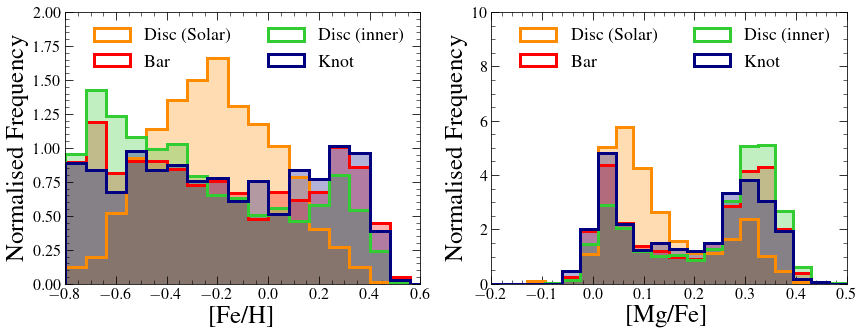

In [34]:

fig, axes = plt.subplots(1, 2,figsize=(14,5),facecolor='white')

axes[0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
axes[0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',histtype='step',lw=3,label='Knot',density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',alpha=0.3,density=True)
axes[0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
axes[0].set_ylabel(r'Normalised Frequency',fontsize=25)
axes[0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0].minorticks_on()
axes[0].set_xlim(-0.8,0.6)
axes[0].set_ylim(0.,2)

axes[1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
axes[1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',histtype='step',lw=3,label='Knot',density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',alpha=0.3,density=True)
axes[1].set_xlabel(r'[Mg/Fe]',fontsize=25)
axes[1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[1].set_ylabel(r'Normalised Frequency',fontsize=25)
axes[1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1].minorticks_on()
axes[1].set_xlim(-0.2,0.5)
axes[1].set_ylim(0.,10)
# plt.figtext(0.35, 0.95,r'Iron and $\alpha$ chemical abundances',fontsize=35)
plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-histograms.pdf',dpi=600, bbox_inches = 'tight')


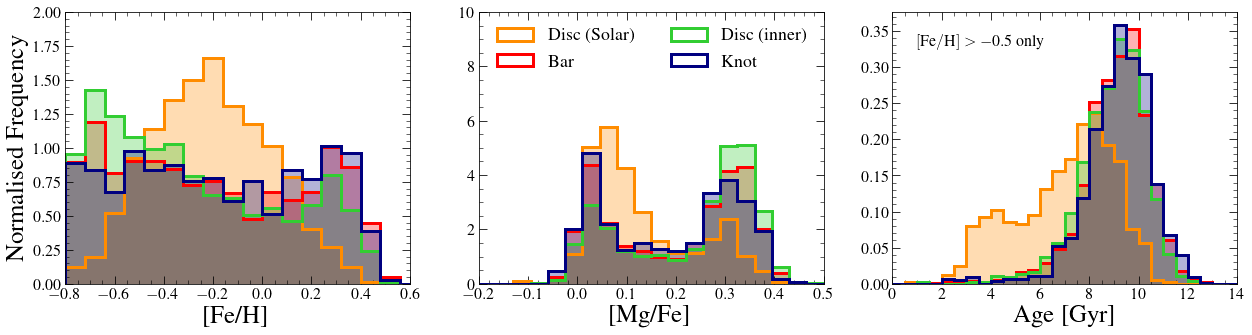

In [50]:

fig, axes = plt.subplots(1, 3,figsize=(21,5),facecolor='white')

axes[0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
axes[0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',histtype='step',lw=3,label='Knot',density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
axes[0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',alpha=0.3,density=True)
axes[0].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
axes[0].set_ylabel(r'Normalised Frequency',fontsize=25)
axes[0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0].minorticks_on()
axes[0].set_xlim(-0.8,0.6)
axes[0].set_ylim(0.,2)

axes[1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
axes[1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',histtype='step',lw=3,label='Knot',density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
axes[1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',alpha=0.3,density=True)
axes[1].set_xlabel(r'[Mg/Fe]',fontsize=25)
axes[1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[1].set_ylabel(r'Normalised Frequency',fontsize=25)
axes[1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1].minorticks_on()
axes[1].set_xlim(-0.2,0.5)
axes[1].set_ylim(0.,10)


axes[2].hist(data_todo['age_lowess_correct'][mask_solar&(data_todo['FE_H']>-0.5)],bins=np.linspace(-0,14,29),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
axes[2].hist(data_todo['age_lowess_correct'][mask_solar&(data_todo['FE_H']>-0.5)],bins=np.linspace(-0,14,29),color='darkorange',alpha=0.3,density=True)
axes[2].hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_bar_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='r',histtype='step',lw=3,label='Bar',density=True)
axes[2].hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_disc_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
axes[2].hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_knot_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='navy',histtype='step',lw=3,label='Knot',density=True)
axes[2].hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_bar_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='r',alpha=0.3,density=True)
axes[2].hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_disc_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='limegreen',alpha=0.3,density=True)
axes[2].hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_knot_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='navy',alpha=0.3,density=True)
axes[2].set_xlabel(r'Age [Gyr]',fontsize=25)
axes[2].text(1,0.33,'$\mathrm{[Fe/H]}>-0.5$ only', fontsize=16)
# axes[2].legend(loc='upper left',fontsize=18,frameon=False)
# axes[2].set_ylabel(r'Normalised Frequency',fontsize=25)
axes[2].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[2].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[2].minorticks_on()
axes[2].set_xlim(0,14)


# plt.figtext(0.35, 0.95,r'Iron and $\alpha$ chemical abundances',fontsize=35)
plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-histograms-withages.pdf',dpi=600, bbox_inches = 'tight')


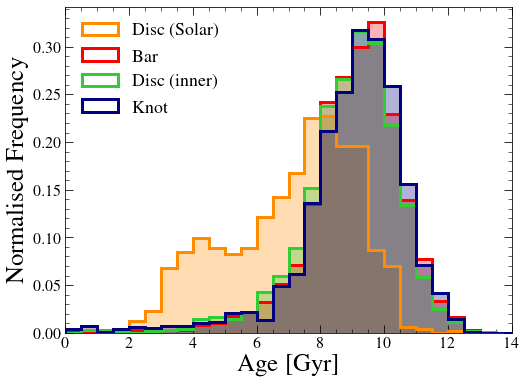

In [42]:
plt.figure(figsize=(8,6),facecolor='white')

plt.hist(data_todo['age_lowess_correct'][mask_solar],bins=np.linspace(-0,14,29),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
plt.hist(data_todo['age_lowess_correct'][mask_solar],bins=np.linspace(-0,14,29),color='darkorange',alpha=0.3,density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',histtype='step',lw=3,label='Knot',density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='navy',alpha=0.3,density=True)
plt.xlabel(r'Age [Gyr]',fontsize=25)
plt.legend(loc='upper left',fontsize=18,frameon=False)
plt.ylabel(r'Normalised Frequency',fontsize=25)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlim(0,14)
# plt.ylim(0.,10)
plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-age-histograms.pdf',dpi=600, bbox_inches = 'tight')


In [49]:
print(np.sum(np.array(median_disc_probability)[mask_u][mask_logg]*data_all['FE_H'][mask_un][mask_logg])/np.sum(np.array(median_disc_probability)[mask_u][mask_logg]))
print(np.sum(np.array(median_bar_probability)[mask_u][mask_logg]*data_all['FE_H'][mask_un][mask_logg])/np.sum(np.array(median_bar_probability)[mask_u][mask_logg]))
print(np.sum(np.array(median_knot_probability)[mask_u][mask_logg]*data_all['FE_H'][mask_un][mask_logg])/np.sum(np.array(median_knot_probability)[mask_u][mask_logg]))

print(np.sum(np.array(median_disc_probability)[mask_u][mask_logg]*data_all['MG_FE'][mask_un][mask_logg])/np.sum(np.array(median_disc_probability)[mask_u][mask_logg]))
print(np.sum(np.array(median_bar_probability)[mask_u][mask_logg]*data_all['MG_FE'][mask_un][mask_logg])/np.sum(np.array(median_bar_probability)[mask_u][mask_logg]))
print(np.sum(np.array(median_knot_probability)[mask_u][mask_logg]*data_all['MG_FE'][mask_un][mask_logg])/np.sum(np.array(median_knot_probability)[mask_u][mask_logg]))

# print(np.nansum(np.array(median_disc_probability)[mask_u][mask_logg]*data_all['age_lowess_correct'][mask_un][mask_logg])/np.nansum(np.array(median_disc_probability)[mask_u][mask_logg]))
# print(np.nansum(np.array(median_bar_probability)[mask_u][mask_logg]*data_all['age_lowess_correct'][mask_un][mask_logg])/np.nansum(np.array(median_bar_probability)[mask_u][mask_logg]))
# print(np.nansum(np.array(median_knot_probability)[mask_u][mask_logg]*data_all['age_lowess_correct'][mask_un][mask_logg])/np.nansum(np.array(median_knot_probability)[mask_u][mask_logg]))



-0.2827608645219278
-0.20417400032026983
-0.17726181771145597
0.22859246681986067
0.19957139255814285
0.18659005665922448


In [ ]:
mask_logg = (data_all['LOGG'][mask_un]>0.5)&(data_all['LOGG'][mask_un]<1.5)&(np.abs(Zgal)[mask_un]<0.3)
# &(rads[mask_un]<3.)
mask_solar_1 = np.load('/Users/dhortadarrington/Documents/Projects/mw-bar/sav/mask_solar.npy',allow_pickle=True)
mask_solar = mask_solar_1&(data_todo['LOGG']>0.5)&(data_todo['LOGG']<1.5) &(np.abs(data_todo['Zgal']*8.178)<0.3)
hist_solar,xedges,yedges = get_2dhist_solar(data_todo['FE_H'][mask_solar],data_todo['MG_FE'][mask_solar])

In [ ]:
plt.figure(figsize=(8,6),facecolor='white')

plt.hist(data_todo['age_lowess_correct'][mask_solar],bins=np.linspace(-0,14,29),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
plt.hist(data_todo['age_lowess_correct'][mask_solar],bins=np.linspace(-0,14,29),color='darkorange',alpha=0.3,density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg],bins=np.linspace(-0,14,29),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)

plt.xlabel(r'Age [Gyr]',fontsize=25)
plt.legend(loc='upper left',fontsize=18,frameon=False)
plt.ylabel(r'Normalised Frequency',fontsize=25)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlim(0,14)
# plt.ylim(0.,10)

# Plot the abundances for other elements

In [59]:
path_abun = '/Users/dhortadarrington/Documents/Projects/mw-bar/data/4Mike-innergal-bar-gaiadists-fullAPOGEE.fits'
tb_abun = fits.open(path_abun)
data_abun = tb_abun[1].data 
print(len(data_abun))

21742


In [63]:
mask_logg = (data_all['LOGG'][mask_un]>0.5)&(data_all['LOGG'][mask_un]<1.5)&(rads[mask_un]<3)
# &(rads[mask_un]<3)

knot_probs = np.array(all_knot_probability)[mask_u][mask_logg].T
bar_probs = np.array(all_bar_probability)[mask_u][mask_logg].T
disc_probs = np.array(all_disc_probability)[mask_u][mask_logg].T

hist_knot = np.zeros((len(knot_probs),50,50))
hist_bar = np.zeros((len(bar_probs),50,50))
hist_disc = np.zeros((len(disc_probs),50,50))

for indx, i in enumerate(knot_probs):
    hist_knot[indx],xedges_knot,yedges_knot = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['AL_FE'][mask_un][mask_logg],i)
    hist_bar[indx],xedges_bar,yedges_bar = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['AL_FE'][mask_un][mask_logg],bar_probs[indx])
    hist_disc[indx],xedges_disc,yedges_disc = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['AL_FE'][mask_un][mask_logg],disc_probs[indx])

    
hist_solar,xedges,yedges = get_2dhist_solar(data_todo['FE_H'][mask_solar],data_todo['AL_FE'][mask_solar])


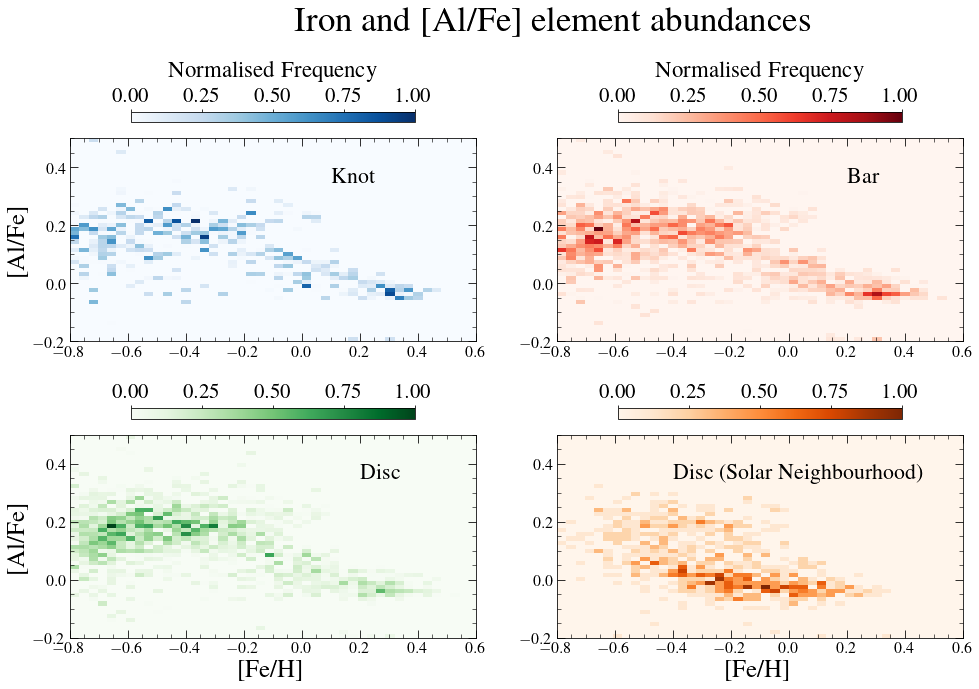

In [64]:

fig, axes = plt.subplots(2, 2,figsize=(16,10),facecolor='white')

plt.figtext(0.32, 1.,r'Iron and [Al/Fe] element abundances',fontsize=35)

color = axes[0,0].imshow((np.nanmedian(hist_knot,axis=0)/np.max(np.nanmedian(hist_knot,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Blues')
axes[0,0].text(0.1,0.35,'Knot',fontsize=22)
# axes[0,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[0,0].set_ylabel(r'[Al/Fe]',fontsize=25)
axes[0,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,0].minorticks_on()
axes[0,0].set_xlim(-0.8,0.6)
axes[0,0].set_ylim(-0.2,0.5)
cax = axes[0,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,0],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[0,1].imshow((np.nanmedian(hist_bar,axis=0)/np.max(np.nanmedian(hist_bar,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Reds')
axes[0,1].text(0.2,0.35,'Bar',fontsize=22)
# axes[0,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[0,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,1].minorticks_on()
axes[0,1].set_xlim(-0.8,0.6)
axes[0,1].set_ylim(-0.2,0.5)
cax = axes[0,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,1],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,0].imshow((np.nanmedian(hist_disc,axis=0)/np.max(np.nanmedian(hist_disc,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Greens')
axes[1,0].text(0.2,0.35,'Disc',fontsize=22)
axes[1,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[1,0].set_ylabel(r'[Al/Fe]',fontsize=25)
axes[1,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,0].minorticks_on()
axes[1,0].set_xlim(-0.8,0.6)
axes[1,0].set_ylim(-0.2,0.5)
cax = axes[1,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,0],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,1].imshow(hist_solar/np.max(hist_solar), extent=[-0.8,0.8,-0.2,0.5],cmap='Oranges')
axes[1,1].text(-.4,0.35,'Disc (Solar Neighbourhood)',fontsize=22)
axes[1,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[1,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,1].minorticks_on()
axes[1,1].set_xlim(-0.8,0.6)
axes[1,1].set_ylim(-0.2,0.5)
cax = axes[1,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,1],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,0].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[2,0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,0].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,0].minorticks_on()
# axes[2,0].set_xlim(-0.8,0.6)
# axes[2,0].set_ylim(0.,2)

# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,1].set_xlabel(r'[Mg/Fe]',fontsize=25)
# axes[2,1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,1].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,1].minorticks_on()
# axes[2,1].set_xlim(-0.2,0.5)
# axes[2,1].set_ylim(0.,10)

plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-aluminium.pdf',dpi=600, bbox_inches = 'tight')


In [65]:
mask_logg = (data_all['LOGG'][mask_un]>0.5)&(data_all['LOGG'][mask_un]<1.5)&(rads[mask_un]<3)
# &(rads[mask_un]<3)

knot_probs = np.array(all_knot_probability)[mask_u][mask_logg].T
bar_probs = np.array(all_bar_probability)[mask_u][mask_logg].T
disc_probs = np.array(all_disc_probability)[mask_u][mask_logg].T

hist_knot = np.zeros((len(knot_probs),50,50))
hist_bar = np.zeros((len(bar_probs),50,50))
hist_disc = np.zeros((len(disc_probs),50,50))

for indx, i in enumerate(knot_probs):
    hist_knot[indx],xedges_knot,yedges_knot = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['NI_FE'][mask_un][mask_logg],i)
    hist_bar[indx],xedges_bar,yedges_bar = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['NI_FE'][mask_un][mask_logg],bar_probs[indx])
    hist_disc[indx],xedges_disc,yedges_disc = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['NI_FE'][mask_un][mask_logg],disc_probs[indx])

    
hist_solar,xedges,yedges = get_2dhist_solar(data_todo['FE_H'][mask_solar],data_todo['NI_FE'][mask_solar])


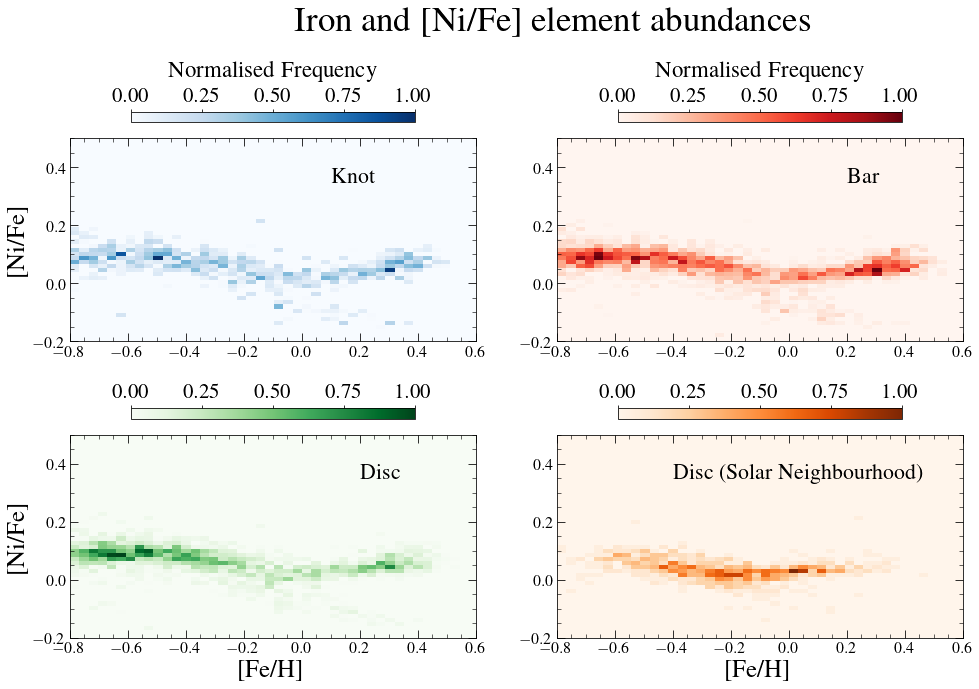

In [66]:

fig, axes = plt.subplots(2, 2,figsize=(16,10),facecolor='white')

plt.figtext(0.32, 1.,r'Iron and [Ni/Fe] element abundances',fontsize=35)

color = axes[0,0].imshow((np.nanmedian(hist_knot,axis=0)/np.max(np.nanmedian(hist_knot,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Blues')
axes[0,0].text(0.1,0.35,'Knot',fontsize=22)
# axes[0,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[0,0].set_ylabel(r'[Ni/Fe]',fontsize=25)
axes[0,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,0].minorticks_on()
axes[0,0].set_xlim(-0.8,0.6)
axes[0,0].set_ylim(-0.2,0.5)
cax = axes[0,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,0],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[0,1].imshow((np.nanmedian(hist_bar,axis=0)/np.max(np.nanmedian(hist_bar,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Reds')
axes[0,1].text(0.2,0.35,'Bar',fontsize=22)
# axes[0,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[0,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,1].minorticks_on()
axes[0,1].set_xlim(-0.8,0.6)
axes[0,1].set_ylim(-0.2,0.5)
cax = axes[0,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,1],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,0].imshow((np.nanmedian(hist_disc,axis=0)/np.max(np.nanmedian(hist_disc,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Greens')
axes[1,0].text(0.2,0.35,'Disc',fontsize=22)
axes[1,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[1,0].set_ylabel(r'[Ni/Fe]',fontsize=25)
axes[1,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,0].minorticks_on()
axes[1,0].set_xlim(-0.8,0.6)
axes[1,0].set_ylim(-0.2,0.5)
cax = axes[1,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,0],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,1].imshow(hist_solar/np.max(hist_solar), extent=[-0.8,0.8,-0.2,0.5],cmap='Oranges')
axes[1,1].text(-.4,0.35,'Disc (Solar Neighbourhood)',fontsize=22)
axes[1,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[1,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,1].minorticks_on()
axes[1,1].set_xlim(-0.8,0.6)
axes[1,1].set_ylim(-0.2,0.5)
cax = axes[1,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,1],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,0].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[2,0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,0].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,0].minorticks_on()
# axes[2,0].set_xlim(-0.8,0.6)
# axes[2,0].set_ylim(0.,2)

# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,1].set_xlabel(r'[Mg/Fe]',fontsize=25)
# axes[2,1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,1].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,1].minorticks_on()
# axes[2,1].set_xlim(-0.2,0.5)
# axes[2,1].set_ylim(0.,10)

plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-nickel.pdf',dpi=600, bbox_inches = 'tight')


In [67]:
mask_logg = (data_all['LOGG'][mask_un]>0.5)&(data_all['LOGG'][mask_un]<1.5)&(rads[mask_un]<3)
# &(rads[mask_un]<3)

knot_probs = np.array(all_knot_probability)[mask_u][mask_logg].T
bar_probs = np.array(all_bar_probability)[mask_u][mask_logg].T
disc_probs = np.array(all_disc_probability)[mask_u][mask_logg].T

hist_knot = np.zeros((len(knot_probs),50,50))
hist_bar = np.zeros((len(bar_probs),50,50))
hist_disc = np.zeros((len(disc_probs),50,50))

for indx, i in enumerate(knot_probs):
    hist_knot[indx],xedges_knot,yedges_knot = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['SI_FE'][mask_un][mask_logg],i)
    hist_bar[indx],xedges_bar,yedges_bar = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['SI_FE'][mask_un][mask_logg],bar_probs[indx])
    hist_disc[indx],xedges_disc,yedges_disc = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['SI_FE'][mask_un][mask_logg],disc_probs[indx])

    
hist_solar,xedges,yedges = get_2dhist_solar(data_todo['FE_H'][mask_solar],data_todo['SI_FE'][mask_solar])


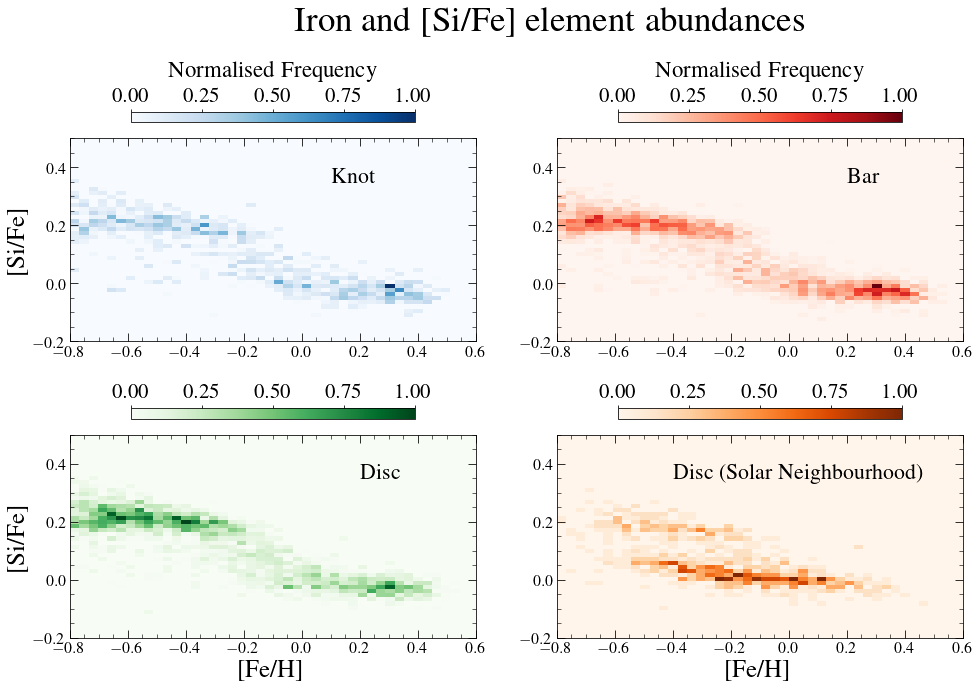

In [69]:

fig, axes = plt.subplots(2, 2,figsize=(16,10),facecolor='white')

plt.figtext(0.32, 1.,r'Iron and [Si/Fe] element abundances',fontsize=35)

color = axes[0,0].imshow((np.nanmedian(hist_knot,axis=0)/np.max(np.nanmedian(hist_knot,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Blues')
axes[0,0].text(0.1,0.35,'Knot',fontsize=22)
# axes[0,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[0,0].set_ylabel(r'[Si/Fe]',fontsize=25)
axes[0,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,0].minorticks_on()
axes[0,0].set_xlim(-0.8,0.6)
axes[0,0].set_ylim(-0.2,0.5)
cax = axes[0,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,0],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[0,1].imshow((np.nanmedian(hist_bar,axis=0)/np.max(np.nanmedian(hist_bar,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Reds')
axes[0,1].text(0.2,0.35,'Bar',fontsize=22)
# axes[0,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[0,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,1].minorticks_on()
axes[0,1].set_xlim(-0.8,0.6)
axes[0,1].set_ylim(-0.2,0.5)
cax = axes[0,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,1],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,0].imshow((np.nanmedian(hist_disc,axis=0)/np.max(np.nanmedian(hist_disc,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Greens')
axes[1,0].text(0.2,0.35,'Disc',fontsize=22)
axes[1,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[1,0].set_ylabel(r'[Si/Fe]',fontsize=25)
axes[1,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,0].minorticks_on()
axes[1,0].set_xlim(-0.8,0.6)
axes[1,0].set_ylim(-0.2,0.5)
cax = axes[1,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,0],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,1].imshow(hist_solar/np.max(hist_solar), extent=[-0.8,0.8,-0.2,0.5],cmap='Oranges')
axes[1,1].text(-.4,0.35,'Disc (Solar Neighbourhood)',fontsize=22)
axes[1,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[1,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,1].minorticks_on()
axes[1,1].set_xlim(-0.8,0.6)
axes[1,1].set_ylim(-0.2,0.5)
cax = axes[1,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,1],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,0].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[2,0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,0].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,0].minorticks_on()
# axes[2,0].set_xlim(-0.8,0.6)
# axes[2,0].set_ylim(0.,2)

# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,1].set_xlabel(r'[Mg/Fe]',fontsize=25)
# axes[2,1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,1].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,1].minorticks_on()
# axes[2,1].set_xlim(-0.2,0.5)
# axes[2,1].set_ylim(0.,10)

plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-silicon.pdf',dpi=600, bbox_inches = 'tight')


In [70]:
mask_logg = (data_all['LOGG'][mask_un]>0.5)&(data_all['LOGG'][mask_un]<1.5)&(rads[mask_un]<3)
# &(rads[mask_un]<3)

knot_probs = np.array(all_knot_probability)[mask_u][mask_logg].T
bar_probs = np.array(all_bar_probability)[mask_u][mask_logg].T
disc_probs = np.array(all_disc_probability)[mask_u][mask_logg].T

hist_knot = np.zeros((len(knot_probs),50,50))
hist_bar = np.zeros((len(bar_probs),50,50))
hist_disc = np.zeros((len(disc_probs),50,50))

for indx, i in enumerate(knot_probs):
    hist_knot[indx],xedges_knot,yedges_knot = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['N_FE'][mask_un][mask_logg],i)
    hist_bar[indx],xedges_bar,yedges_bar = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['N_FE'][mask_un][mask_logg],bar_probs[indx])
    hist_disc[indx],xedges_disc,yedges_disc = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['N_FE'][mask_un][mask_logg],disc_probs[indx])

    
hist_solar,xedges,yedges = get_2dhist_solar(data_todo['FE_H'][mask_solar],data_todo['N_FE'][mask_solar])


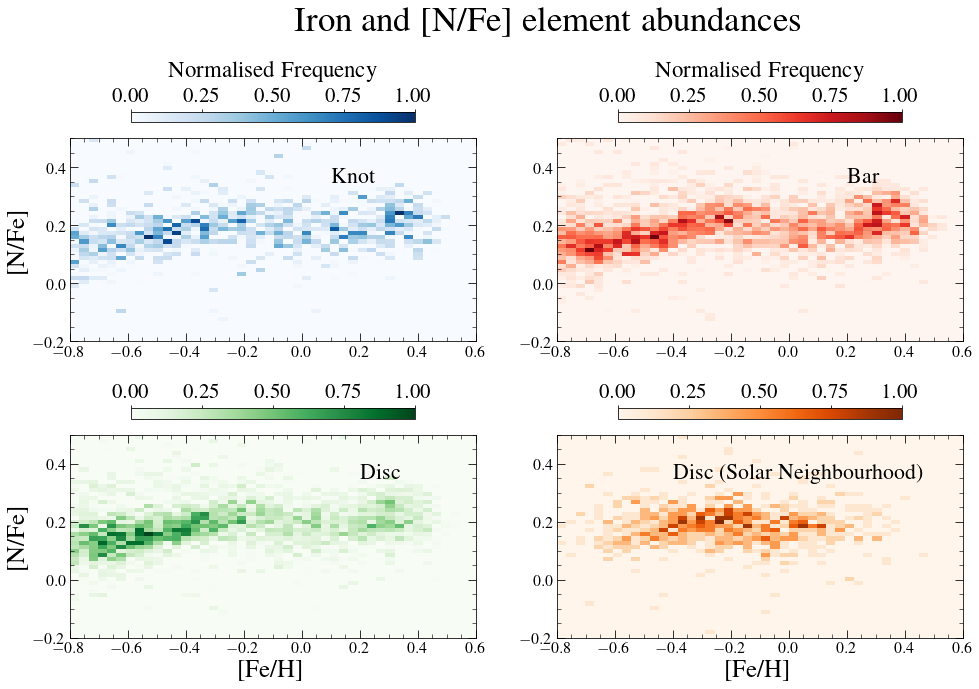

In [71]:

fig, axes = plt.subplots(2, 2,figsize=(16,10),facecolor='white')

plt.figtext(0.32, 1.,r'Iron and [N/Fe] element abundances',fontsize=35)

color = axes[0,0].imshow((np.nanmedian(hist_knot,axis=0)/np.max(np.nanmedian(hist_knot,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Blues')
axes[0,0].text(0.1,0.35,'Knot',fontsize=22)
# axes[0,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[0,0].set_ylabel(r'[N/Fe]',fontsize=25)
axes[0,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,0].minorticks_on()
axes[0,0].set_xlim(-0.8,0.6)
axes[0,0].set_ylim(-0.2,0.5)
cax = axes[0,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,0],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[0,1].imshow((np.nanmedian(hist_bar,axis=0)/np.max(np.nanmedian(hist_bar,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Reds')
axes[0,1].text(0.2,0.35,'Bar',fontsize=22)
# axes[0,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[0,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,1].minorticks_on()
axes[0,1].set_xlim(-0.8,0.6)
axes[0,1].set_ylim(-0.2,0.5)
cax = axes[0,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,1],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,0].imshow((np.nanmedian(hist_disc,axis=0)/np.max(np.nanmedian(hist_disc,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Greens')
axes[1,0].text(0.2,0.35,'Disc',fontsize=22)
axes[1,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[1,0].set_ylabel(r'[N/Fe]',fontsize=25)
axes[1,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,0].minorticks_on()
axes[1,0].set_xlim(-0.8,0.6)
axes[1,0].set_ylim(-0.2,0.5)
cax = axes[1,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,0],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,1].imshow(hist_solar/np.max(hist_solar), extent=[-0.8,0.8,-0.2,0.5],cmap='Oranges')
axes[1,1].text(-.4,0.35,'Disc (Solar Neighbourhood)',fontsize=22)
axes[1,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[1,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,1].minorticks_on()
axes[1,1].set_xlim(-0.8,0.6)
axes[1,1].set_ylim(-0.2,0.5)
cax = axes[1,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,1],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,0].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[2,0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,0].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,0].minorticks_on()
# axes[2,0].set_xlim(-0.8,0.6)
# axes[2,0].set_ylim(0.,2)

# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,1].set_xlabel(r'[Mg/Fe]',fontsize=25)
# axes[2,1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,1].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,1].minorticks_on()
# axes[2,1].set_xlim(-0.2,0.5)
# axes[2,1].set_ylim(0.,10)

plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-nitrogen.pdf',dpi=600, bbox_inches = 'tight')


In [72]:
mask_logg = (data_all['LOGG'][mask_un]>0.5)&(data_all['LOGG'][mask_un]<1.5)&(rads[mask_un]<3)
# &(rads[mask_un]<3)

knot_probs = np.array(all_knot_probability)[mask_u][mask_logg].T
bar_probs = np.array(all_bar_probability)[mask_u][mask_logg].T
disc_probs = np.array(all_disc_probability)[mask_u][mask_logg].T

hist_knot = np.zeros((len(knot_probs),50,50))
hist_bar = np.zeros((len(bar_probs),50,50))
hist_disc = np.zeros((len(disc_probs),50,50))

for indx, i in enumerate(knot_probs):
    hist_knot[indx],xedges_knot,yedges_knot = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['C_FE'][mask_un][mask_logg],i)
    hist_bar[indx],xedges_bar,yedges_bar = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['C_FE'][mask_un][mask_logg],bar_probs[indx])
    hist_disc[indx],xedges_disc,yedges_disc = get_2dhist(data_all['FE_H'][mask_un][mask_logg],data_abun['C_FE'][mask_un][mask_logg],disc_probs[indx])

    
hist_solar,xedges,yedges = get_2dhist_solar(data_todo['FE_H'][mask_solar],data_todo['C_FE'][mask_solar])


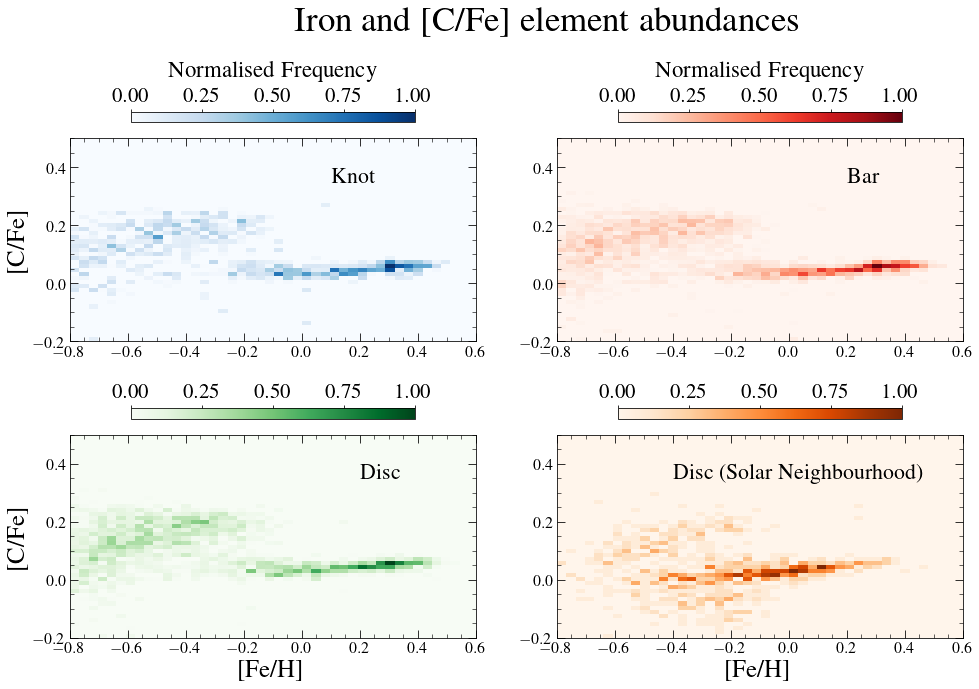

In [73]:

fig, axes = plt.subplots(2, 2,figsize=(16,10),facecolor='white')

plt.figtext(0.32, 1.,r'Iron and [C/Fe] element abundances',fontsize=35)

color = axes[0,0].imshow((np.nanmedian(hist_knot,axis=0)/np.max(np.nanmedian(hist_knot,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Blues')
axes[0,0].text(0.1,0.35,'Knot',fontsize=22)
# axes[0,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[0,0].set_ylabel(r'[C/Fe]',fontsize=25)
axes[0,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,0].minorticks_on()
axes[0,0].set_xlim(-0.8,0.6)
axes[0,0].set_ylim(-0.2,0.5)
cax = axes[0,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,0],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[0,1].imshow((np.nanmedian(hist_bar,axis=0)/np.max(np.nanmedian(hist_bar,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Reds')
axes[0,1].text(0.2,0.35,'Bar',fontsize=22)
# axes[0,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[0,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,1].minorticks_on()
axes[0,1].set_xlim(-0.8,0.6)
axes[0,1].set_ylim(-0.2,0.5)
cax = axes[0,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,1],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,0].imshow((np.nanmedian(hist_disc,axis=0)/np.max(np.nanmedian(hist_disc,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Greens')
axes[1,0].text(0.2,0.35,'Disc',fontsize=22)
axes[1,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[1,0].set_ylabel(r'[C/Fe]',fontsize=25)
axes[1,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,0].minorticks_on()
axes[1,0].set_xlim(-0.8,0.6)
axes[1,0].set_ylim(-0.2,0.5)
cax = axes[1,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,0],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,1].imshow(hist_solar/np.max(hist_solar), extent=[-0.8,0.8,-0.2,0.5],cmap='Oranges')
axes[1,1].text(-.4,0.35,'Disc (Solar Neighbourhood)',fontsize=22)
axes[1,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[1,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,1].minorticks_on()
axes[1,1].set_xlim(-0.8,0.6)
axes[1,1].set_ylim(-0.2,0.5)
cax = axes[1,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,1],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,0].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[2,0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,0].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,0].minorticks_on()
# axes[2,0].set_xlim(-0.8,0.6)
# axes[2,0].set_ylim(0.,2)

# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,1].set_xlabel(r'[Mg/Fe]',fontsize=25)
# axes[2,1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,1].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,1].minorticks_on()
# axes[2,1].set_xlim(-0.2,0.5)
# axes[2,1].set_ylim(0.,10)

plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-carbon.pdf',dpi=600, bbox_inches = 'tight')


# Now try it with the Bovy et al 2019 cut

In [46]:
z_todo = data_todo['Zgal']*8.178
R_todo = data_todo['Rgal']*8.178

mask_solar_bovy = (np.abs(z_todo)<2)&(np.abs(z_todo)>0.5)&(R_todo>5)&(R_todo<10)&(data_todo['age_lowess_correct']>8)
mask_solar = mask_solar_bovy&(data_todo['LOGG']>0.5)&(data_todo['LOGG']<1.5) 
# &(np.abs(data_todo['Zgal']*8.178)<0.3)
hist_solar,xedges,yedges = get_2dhist_solar(data_todo['FE_H'][mask_solar],data_todo['MG_FE'][mask_solar])


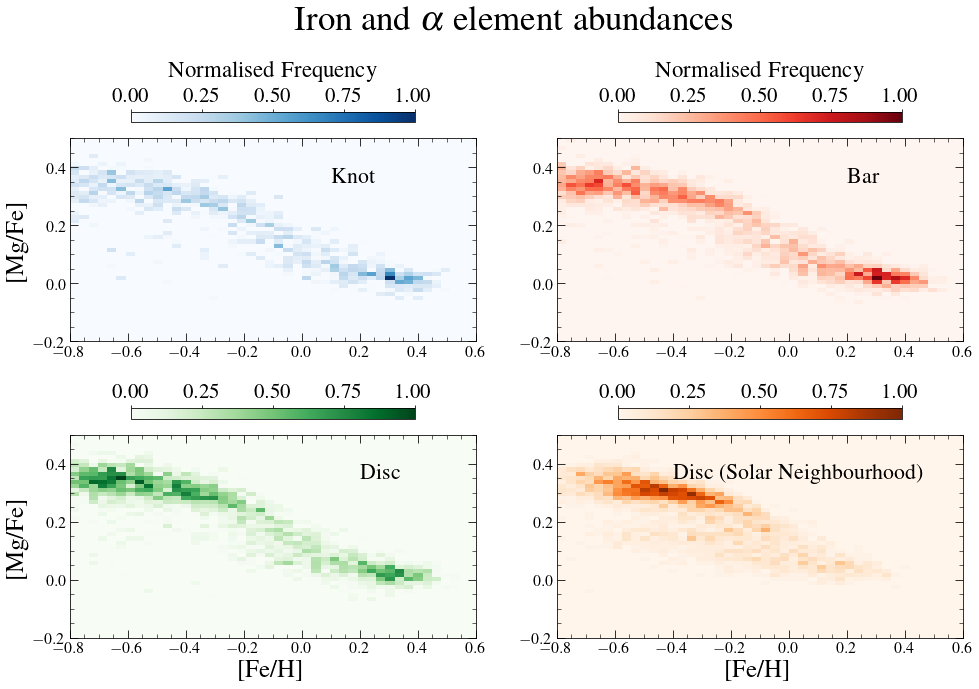

In [47]:

fig, axes = plt.subplots(2, 2,figsize=(16,10),facecolor='white')

plt.figtext(0.32, 1.,r'Iron and $\alpha$ element abundances',fontsize=35)

color = axes[0,0].imshow((np.nanmedian(hist_knot,axis=0)/np.max(np.nanmedian(hist_knot,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Blues')
axes[0,0].text(0.1,0.35,'Knot',fontsize=22)
# axes[0,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[0,0].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,0].minorticks_on()
axes[0,0].set_xlim(-0.8,0.6)
axes[0,0].set_ylim(-0.2,0.5)
cax = axes[0,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,0],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[0,1].imshow((np.nanmedian(hist_bar,axis=0)/np.max(np.nanmedian(hist_bar,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Reds')
axes[0,1].text(0.2,0.35,'Bar',fontsize=22)
# axes[0,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[0,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[0,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[0,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[0,1].minorticks_on()
axes[0,1].set_xlim(-0.8,0.6)
axes[0,1].set_ylim(-0.2,0.5)
cax = axes[0,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[0,1],cax=cax,orientation='horizontal')
cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,0].imshow((np.nanmedian(hist_disc,axis=0)/np.max(np.nanmedian(hist_disc,axis=0))), extent=[-0.8,0.8,-0.2,0.5],cmap='Greens')
axes[1,0].text(0.2,0.35,'Disc',fontsize=22)
axes[1,0].set_xlabel(r'[Fe/H]',fontsize=25)
axes[1,0].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,0].minorticks_on()
axes[1,0].set_xlim(-0.8,0.6)
axes[1,0].set_ylim(-0.2,0.5)
cax = axes[1,0].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,0],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

color = axes[1,1].imshow(hist_solar/np.max(hist_solar), extent=[-0.8,0.8,-0.2,0.5],cmap='Oranges')
axes[1,1].text(-.4,0.35,'Disc (Solar Neighbourhood)',fontsize=22)
axes[1,1].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[1,1].set_ylabel(r'[Mg/Fe]',fontsize=25)
axes[1,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
axes[1,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
axes[1,1].minorticks_on()
axes[1,1].set_xlim(-0.8,0.6)
axes[1,1].set_ylim(-0.2,0.5)
cax = axes[1,1].inset_axes([0.15, 1.08, 0.7, 0.05])
cbar = fig.colorbar(color,ax=axes[1,1],cax=cax,orientation='horizontal')
# cbar.set_label(label=r'Normalised Frequency',fontsize=23,labelpad=10)
cbar.ax.tick_params(labelsize=21)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,0].hist(data_todo['FE_H'][mask_solar],bins=np.linspace(-0.8,0.8,21),color='darkorange',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,0].hist(data_all['FE_H'][mask_un][mask_logg],bins=np.linspace(-0.8,0.8,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,0].set_xlabel(r'[Fe/H]',fontsize=25)
# axes[2,0].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,0].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,0].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,0].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,0].minorticks_on()
# axes[2,0].set_xlim(-0.8,0.6)
# axes[2,0].set_ylim(0.,2)

# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar)')
# axes[2,1].hist(data_todo['MG_FE'][mask_solar],bins=np.linspace(-0.2,0.5,21),color='darkorange',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',histtype='step',lw=3,label='Knot',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',histtype='step',lw=3,label='Bar',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_knot_probability)[mask_u][mask_logg],color='indigo',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_bar_probability)[mask_u][mask_logg],color='r',alpha=0.3,density=True)
# axes[2,1].hist(data_all['MG_FE'][mask_un][mask_logg],bins=np.linspace(-0.2,0.5,21),weights=np.array(median_disc_probability)[mask_u][mask_logg],color='limegreen',alpha=0.3,density=True)
# axes[2,1].set_xlabel(r'[Mg/Fe]',fontsize=25)
# axes[2,1].legend(loc='upper right',fontsize=18,frameon=False,ncol=2)
# axes[2,1].set_ylabel(r'Normalised Frequency',fontsize=25)
# axes[2,1].tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
# axes[2,1].tick_params(which='minor', length=4, direction='in',top=True,right=True)
# axes[2,1].minorticks_on()
# axes[2,1].set_xlim(-0.2,0.5)
# axes[2,1].set_ylim(0.,10)

# plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-alpha-bovy-comp.pdf',dpi=600, bbox_inches = 'tight')


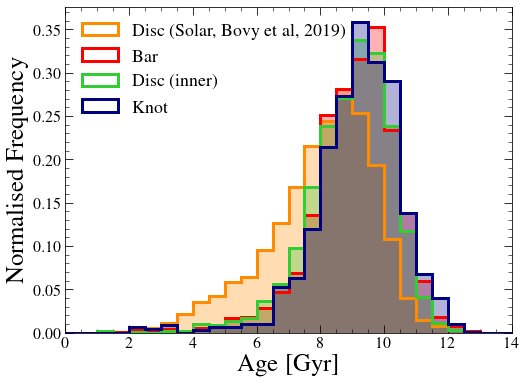

In [45]:
plt.figure(figsize=(8,6),facecolor='white')

plt.hist(data_todo['age_lowess_correct'][mask_solar&(data_todo['FE_H']>-0.5)],bins=np.linspace(-0,14,29),color='darkorange',histtype='step',lw=3,density=True,label='Disc (Solar, Bovy et al, 2019)')
plt.hist(data_todo['age_lowess_correct'][mask_solar&(data_todo['FE_H']>-0.5)],bins=np.linspace(-0,14,29),color='darkorange',alpha=0.3,density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_bar_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='r',histtype='step',lw=3,label='Bar',density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_disc_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='limegreen',histtype='step',lw=3,label='Disc (inner)',density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_knot_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='navy',histtype='step',lw=3,label='Knot',density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_bar_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='r',alpha=0.3,density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_disc_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='limegreen',alpha=0.3,density=True)
plt.hist(data_all['age_lowess_correct'][mask_un][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],bins=np.linspace(-0,14,29),weights=np.array(median_knot_probability)[mask_u][mask_logg&(data_all['FE_H'][mask_un]>-0.5)],color='navy',alpha=0.3,density=True)
plt.xlabel(r'Age [Gyr]',fontsize=25)
plt.legend(loc='upper left',fontsize=18,frameon=False)
plt.ylabel(r'Normalised Frequency',fontsize=25)
plt.tick_params(which='major',labelsize=16,direction='in',top=True,right=True,length=8)
plt.tick_params(which='minor', length=4, direction='in',top=True,right=True)
plt.minorticks_on()
plt.xlim(0,14)
# plt.ylim(0.,10)
plt.savefig('../plots-paper/abundances-norm-3kpc-loggcut-age-histograms-bovy-comp.pdf',dpi=600, bbox_inches = 'tight')
